In [363]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import torch.optim as optim
import os
import datetime
import yaml
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, Dataset
import json
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from tqdm import tqdm_notebook
import numpy as np
import re
import copy

In [364]:
converter={}
converter["AA"]="ɑ"
converter["AE"]="æ"
converter["AH"]="ʌ"
converter["AO"]="ɔ"
converter["AW"]="aʊ"
# converter["AX"]="ə"
# converter["AXR"]="ɚ"
converter["AY"]="aɪ"
converter["EH"]="ɛ"
converter["ER"]="ɝ"
converter["EY"]="eɪ"
converter["IH"]="ɪ"
# converter["IX"]="ɨ"
converter["IY"]="i"
converter["OW"]="oʊ"
converter["OY"]="ɔɪ"
converter["UH"]="ʊ"
converter["UW"]="u"
# converter["UX"]="ʉ"
converter["B"]="b"
converter["CH"]="tʃ"
converter["D"]="d"
converter["DH"]="ð"
# converter["DX"]="ɾ"
# converter["EL"]="l̩"
# converter["EM"]="m̩"
# converter["EN"]="n̩"
converter["F"]="f"
converter["G"]="ɡ"
# converter["H"]="h"
converter["HH"]="h"
converter["JH"]="dʒ"
converter["K"]="k"
converter["L"]="l"
converter["M"]="m"
converter["N"]="n"
# converter["NX"]="ɾ̃"
converter["NG"]="ŋ"
converter["P"]="p"
# converter["Q"]="ʔ"
converter["R"]="ɹ"
converter["S"]="s"
converter["SH"]="ʃ"
converter["T"]="t"
converter["TH"]="θ"
converter["V"]="v"
converter["W"]="w"
# converter["WH"]="ʍ"
converter["Y"]="j"
converter["Z"]="z"
converter["ZH"]="ʒ"
converter[' ']="SIL"

mapping={}
mapping["अ"]="ə"
mapping["आ"]="a:"
mapping["इ"]="ɪ"
mapping["ई"]="i:"
mapping["उ"]="ʊ"
mapping["ऊ"]="u:"
mapping["ऋ"]="ɻ̩"
mapping["ए"]="e:"
mapping["ऐ"]="ɛ:"
mapping["ओ"]="o:"
mapping["औ"]="ɔ:"
#mapping["अँ"]="/ə̃/"
#mapping["अः"]="/əɦə/"
mapping["अं"]="əm"
#mapping["ऑ"]="/ɒ/"


mapping["ा"]="a:"
mapping["ि"]="ɪ"
mapping["ी"]="i:"
mapping["ु"]="ʊ"
mapping["ू"]="u:"
mapping["ृ"]="ɻ̩"
mapping["े"]="e:"
mapping["ै"]="ɛ:"
mapping["ो"]="o:"
mapping["ौ"]="ɔ:"
#mapping["ँ"]="/ə̃/"
#mapping["ː"]="/əɦə/"
mapping['ं']="əm"
mapping["ॆ"]="e:"

mapping["क"+"्"]="k"
mapping["ख"+"्"]="kʰ"
mapping["ग"+"्"]="g"
mapping["घ"+"्"]="gʰ"
mapping["ङ"+"्"]="ŋ"
mapping["च"+"्"]="tʃ"
mapping["छ"+"्"]="tʃʰ"
mapping["ज"+"्"]="dʒ"
mapping["झ"+"्"]="dʒʰ"
mapping["ञ"+"्"]="ɲ"
mapping["ट"+"्"]="ʈ"
mapping["ठ"+"्"]="ʈʰ"
mapping["ड"+"्"]="ɖ"
mapping["ढ"+"्"]="ɖʰ"
mapping["ण"+"्"]="ɳ"
mapping["त"+"्"]="t̪"
mapping["थ"+"्"]="t̪ʰ"
mapping["द"+"्"]="d̪"
mapping["ध"+"्"]="d̪ʰ"
mapping["न"+"्"]="n"
mapping["प"+"्"]="p"
mapping["फ"+"्"]="pʰ"
mapping["ब"+"्"]="b"
mapping["भ"+"्"]="bʰ"
mapping["म"+"्"]="m"
mapping["य"+"्"]="j"
mapping["र"+"्"]="ɾ"
mapping["ल"+"्"]="l"
mapping["व"+"्"]="ʋ"
mapping["स"+"्"]="s"
mapping["श"+"्"]="ʃ"
mapping["ष"+"्"]="ʂ"
mapping["ह"+"्"]="ɦ"
mapping["ळ"+"्"]="ɭ̆ɭ̆"
mapping[" "]="SIL"

def Merge(dict1, dict2):
    return(dict2.update(dict1))

Merge(mapping, converter)
 
# changes made in dict2
print(len(converter))

98


In [365]:
!pip install g2p-en

In [4]:
from g2p_en import G2p

texts = ["I have $250 in my pocket", # number -> spell-out
         "popular pets, e.g. cats and dogs", # e.g. -> for example
         "I refuse to collect the refuse around here", # homograph
         "I'm an activationist",
         "Merecedes",
         "REDMI",
         "letter",
         "xiaomi",
         "bite",
         "flower⏱️",
         "hundred⏱️",
         "nahi huya hai",
         "karyavahi⏱️",
         "die",
         "block…"] # newly coined word
g2p = G2p()
for text in texts:
    s=[]
    out = g2p(text)
    print(out)
    for x in range(len(out)):
      # print(x)
      out[x]=re.sub(r"[0-9]","",out[x])
      # print(x)
      out[x]=re.sub(r"\.","",out[x])
      out[x]=re.sub(r"\,","",out[x])
      # x=re.sub(r"[\!]","",x)
      # x=re.sub(r"\?","",x)
      # print(x)
      if out[x]!="":
        s.append(converter[out[x]])
      # print(out[x])
    print(s)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.
['AY1', ' ', 'HH', 'AE1', 'V', ' ', 'T', 'UW1', ' ', 'HH', 'AH1', 'N', 'D', 'R', 'AH0', 'D', ' ', 'F', 'IH1', 'F', 'T', 'IY0', ' ', 'D', 'AA1', 'L', 'ER0', 'Z', ' ', 'IH0', 'N', ' ', 'M', 'AY1', ' ', 'P', 'AA1', 'K', 'AH0', 'T']
['aɪ', 'SIL', 'h', 'æ', 'v', 'SIL', 't', 'u', 'SIL', 'h', 'ʌ', 'n', 'd', 'ɹ', 'ʌ', 'd', 'SIL', 'f', 'ɪ', 'f', 't', 'i', 'SIL', 'd', 'ɑ', 'l', 'ɝ', 'z', 'SIL', 'ɪ', 'n', 'SIL', 'm', 'aɪ', 'SIL', 'p', 'ɑ', 'k', 'ʌ', 't']
['P', 'AA1', 'P', 'Y', 'AH0', 'L', 'ER0', ' ', 'P', 'EH1', 'T', 'S', ' ', ',', ' ', 'F', 'AO1', 'R', ' ', 'IH0', 'G', 'Z', 'AE1', 'M', 'P', 'AH0', 'L', ' ', 'K', 'AE1', 'T', 'S', ' ', 'AH0', 'N', 'D', ' ', 'D', 'AA1', 'G', 'Z']
['p', 'ɑ', 'p', 'j', 'ʌ', 'l', 'ɝ', 'SIL', 'p', 'ɛ', 't'

In [5]:
import re

def text_phonemes(text="पढ़ती हैं"):
  vowels=["ा","ि","ी","ु","ू","ृ","े","ै","ो","ौ","ँ",'ं','ॆ',"ː","आ","इ","ई","उ","ऊ","ऋ","ए","ऐ","ओ","औ","अः","अं"]
  full_consonants=["क","ख","ग","घ","ङ","च","छ","ज","झ","ञ","ट","ठ","ड","ढ","ण","त","थ","द","ध","न","प","फ","ब","भ","म","य","र","ल","ळ","व","श","ष","स","ह"]
  special_vowels=["ः","ं","ँ"]
  mapping={}
  mapping["अ"]="ə"
  mapping["आ"]="a:"
  mapping["इ"]="ɪ"
  mapping["ई"]="i:"
  mapping["उ"]="ʊ"
  mapping["ऊ"]="u:"
  mapping["ऋ"]="ɻ̩"
  mapping["ए"]="e:"
  mapping["ऐ"]="ɛ:"
  mapping["ओ"]="o:"
  mapping["औ"]="ɔ:"
  #mapping["अँ"]="/ə̃/"
  #mapping["अः"]="/əɦə/"
  mapping["अं"]="əm"
  #mapping["ऑ"]="/ɒ/"


  mapping["ा"]="a:"
  mapping["ि"]="ɪ"
  mapping["ी"]="i:"
  mapping["ु"]="ʊ"
  mapping["ू"]="u:"
  mapping["ृ"]="ɻ̩"
  mapping["े"]="e:"
  mapping["ै"]="ɛ:"
  mapping["ो"]="o:"
  mapping["ौ"]="ɔ:"
  #mapping["ँ"]="/ə̃/"
  #mapping["ː"]="/əɦə/"
  mapping['ं']="əm"
  mapping["ॆ"]="e:"

  mapping["क"+"्"]="k"
  mapping["ख"+"्"]="kʰ"
  mapping["ग"+"्"]="g"
  mapping["घ"+"्"]="gʰ"
  mapping["ङ"+"्"]="ŋ"
  mapping["च"+"्"]="tʃ"
  mapping["छ"+"्"]="tʃʰ"
  mapping["ज"+"्"]="dʒ"
  mapping["झ"+"्"]="dʒʰ"
  mapping["ञ"+"्"]="ɲ"
  mapping["ट"+"्"]="ʈ"
  mapping["ठ"+"्"]="ʈʰ"
  mapping["ड"+"्"]="ɖ"
  mapping["ढ"+"्"]="ɖʰ"
  mapping["ण"+"्"]="ɳ"
  mapping["त"+"्"]="t̪"
  mapping["थ"+"्"]="t̪ʰ"
  mapping["द"+"्"]="d̪"
  mapping["ध"+"्"]="d̪ʰ"
  mapping["न"+"्"]="n"
  mapping["प"+"्"]="p"
  mapping["फ"+"्"]="pʰ"
  mapping["ब"+"्"]="b"
  mapping["भ"+"्"]="bʰ"
  mapping["म"+"्"]="m"
  mapping["य"+"्"]="j"
  mapping["र"+"्"]="ɾ"
  mapping["ल"+"्"]="l"
  mapping["व"+"्"]="ʋ"
  mapping["स"+"्"]="s"
  mapping["श"+"्"]="ʃ"
  mapping["ष"+"्"]="ʂ"
  mapping["ह"+"्"]="ɦ"
  mapping["ळ"+"्"]="ɭ̆ɭ̆"
  mapping[" "]="SIL"


  #text="नमस्कार नमस्कार नमस्कार नमस्कार नमस्कार नमस्कार नमस्कार नमस्कार "
  line=text.split("\n")
  for i in range(len(line)):
    line[i]=line[i].strip()
  # print(line)
  b=[]

  for k in range(len(line)):
    x=str(b)+str("_")+str(k)
    x=[]
    a=line[k]
    a_1=re.split(" ",a)
    #print(a_1)
    
    for i in range(len(a_1)):
      for j in range(len(a_1[i])):
      
        #print(a_1[i])
        x.append(a_1[i][j])
      x.append("  ")
    b.append(x)

  for i in range(len(b)):
    for j in range(len(b[i])):
      if b[i][j]=="अ" and b[i][j+1] in special_vowels:
        b[i][j]="अ"+b[i][j+1]
        b[i][j+1]="."
    if "." in b[i]:
      b[i].remove(".")

  for i in range(len(b)):
    for j in range(len(b[i])):
      if b[i][j]=="्":
        #print(b[i-1],i)
        b[i][j-1]=b[i][j-1]+b[i][j]
        b[i][j]=""

  for i in range(len(b)):
    for j in range(3*len(b[i])):
      if j < len(b[i]):
        if b[i][j] in full_consonants and b[i][j+1] not in vowels:
          b[i][j]=b[i][j]+"्"
          b[i].insert(j+1,"अ")

    if b[i][len(b[i])-2] in full_consonants:
      b[i][len(b[i])-2]=b[i][len(b[i])-2]+"्"
      b[i].insert(len(b[i])-1,"अ")

  c=[]
  indices=[]
  for i in range(len(b)):
    y=str(c)+str("_")+str(i)
    y=[]
    for j in range(len(b[i])):
      if b[i][j]!="":
        y.append(b[i][j])
    c.append(y)


  for k in range(len(c)):
    for i in range(1,len(c[k])):
      if c[k][i] in vowels and c[k][i-1] not in vowels:
        c[k][i-1]=c[k][i-1]+"्"

  phones=[]

  for i in range(len(c)):
    z=str(phones)+str("_")+str(i)
    z=[]
    values=''
    for char in c[i]:  
      if char=='  ':
        z.append(values)
        values=''
        
      else:
        for key,value in mapping.items():
          if char == key:
            values=values+value+" "
      
      
    phones.append(z)

  phones_final=[]
  for i in range(len(phones)):
    z=str(phones_final)+str("_")+str(i)
    z=[]
    for j in range(len(phones[i])):
      if len(phones[i][j])==0:
        break
      else:
        z.append(phones[i][j])
    
    phones_final.append(z)
  for j in range(len(phones_final)):
    for i in range(1,5*len(phones_final[j]),2):
      if i<len(phones_final[j]):
        phones_final[j].insert(i,"SIL")
  # print(phones_final)
  # phonemes=[]
  # for i in range(len(phones_final[0])):
  #   for j in range(len(phones_final[0][i])):
  #     phonemes.append(phones_final[0][i][j].split(" "))
  phonemes=[]
  temp_pho=[]
  for j in range(len(phones_final)):
    a=[]
    for i in range(len(phones_final[j])):
      a.append(phones_final[j][i])
    temp_pho.append(a)
  # print(temp_pho)
  for j in range(len(temp_pho)):
    x=[]
    for i in range(len(temp_pho[j])):
      temp_pho[j][i]=temp_pho[j][i].strip()
      x.append(temp_pho[j][i].split(" "))
    phonemes.append(x)
  # print(phonemes)
  phonemes_final=[]
  for i in range(len(phonemes)):
    y=[]
    for j in range(len(phonemes[i])):
      for k in range(len(phonemes[i][j])):
        y.append(phonemes[i][j][k])
    phonemes_final.append(y)


  return phonemes_final

In [6]:
text_phonemes()

[['p', 'ə', 'ɖʰ', 'ə', 't̪', 'i:', 'SIL', 'ɦ', 'ɛ:', 'əm']]

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding, emb_dim, fmaps, strides, dropout_factor, num_classes):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim).from_pretrained(embedding, freeze=False)
        conv_layers = [nn.Conv2d(1, fmaps, (stride, emb_dim), padding=(stride-1, 0)) for stride in strides]
        self.conv_layers = nn.Sequential(*conv_layers)
        self.dropout = nn.Dropout(dropout_factor)
        self.fc = nn.Linear(len(conv_layers)*fmaps, num_classes)
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.conv_layers]
        x = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [389]:
data=pd.read_excel("/content/drive/MyDrive/Inter IIT/dev_data_tweet.xlsx")

In [369]:
data=pd.read_csv("/content/drive/MyDrive/Inter IIT/article_clean.csv")

In [370]:
data.head()

,Text,Headline,Mobile_Tech
0,NaN,NaN,NaN
1,Digitisation is one of the key buzzwords in th...,Pakistan’s digital landscape post-Covid,0.0
2,Increase in tolerance limit up to 120 per cent...,Affordable housing gets shot in the arm,0.0
3,tax & consulting group in India)Disclaimer: T...,Affordable housing gets shot in the arm,0.0
4,Home > News > World Sports NewsJonas Lossl lea...,Jonas Lossl leaves Everton to rejoin first clu...,0.0


In [ ]:
data["Tweet"].values[139]

'RT @ewarren: Canceling student loan debt would immediately put money in the pockets of millions of Americans. It would help dig our economy out of this crisis. And we don’t have to wait for Congress: the Biden-Harris administration can get it done with their executive authority.'

In [395]:
# removing stopwords
text=[]
for i in range(data.shape[0]):
  text.append(data["Tweet"].values[i])
  # print(i)
  text[i]=re.sub(r"https\S+", "", str(text[i]))
  text[i]=re.sub(r"http\S+", "", text[i])
  text[i]=re.sub(r"@\S+", "", text[i])
  text[i]=re.sub(r"Cc\S+", "", text[i])
  text[i]=re.sub(r"[0-9]","",text[i])
  text[i]=re.sub(r"#","",text[i])
  text[i]=re.sub(r"-"," ",text[i])
  text[i]=re.sub(r"/"," or ",text[i])
  text[i]=re.sub(r"&"," and ",text[i])
  text[i]=re.sub(r"\'ll"," will ",text[i])
  text[i]=re.sub(r"[,.?!$%^*@:][\'।\'\"]"," ",text[i])
  text[i]=re.sub(r"\?"," ",text[i])
  text[i]=re.sub(r"\>"," ",text[i])
  text[i]=re.sub(r"\<"," ",text[i])
  text[i]=re.sub(r"\."," ",text[i])
  text[i]=re.sub(r"\'"," ",text[i])
  text[i]=re.sub(r"_"," ",text[i])
  text[i]=re.sub(r"-"," ",text[i])
  text[i]=re.sub(r"\("," ",text[i])
  text[i]=re.sub(r"\'"," ",text[i])
  text[i]=re.sub(r"\)"," ",text[i])
  text[i]=re.sub(r"[\U00010000-\U0010ffff]","",text[i],flags=re.UNICODE)
  text[i]=re.sub(r"RT","",text[i])
  text[i]=re.sub(r"–"," ",text[i])
  text[i]=re.sub(r"\s+"," ",text[i])
  text[i]=text[i].lower()
  text[i]=' '.join( [w for w in text[i].split() if len(w)>1] )
  text[i]=text[i].strip()

print(text[0])

you will my pitchwars book if you like: hate to love ownvoices ace or aro rep subdued mythology ride or die queerplatonic bonds fast pace, high risk star and plant imagery everywhere getting punched in your emotions pwparty⏱️


In [ ]:
text1=[]
for i in range(data.shape[0]):
  if data["Mobile_Tech_Tag"].values[i]==1:
    copy1=text[i]
    copy2=text[i]
    words=text[i].split()
    if "smartphone" in words:
      text1.append(copy1.replace("smartphone","phone"))
      text1.append(copy2.replace("smartphone","mobile"))
    elif "smartphones" in words:
      text1.append(copy1.replace("smartphones","phones"))
      text1.append(copy2.replace("smartphones","mobiles"))
    elif "स्मार्टफोन" in words:
      text1.append(copy1.replace("स्मार्टफोन","फोन"))
      text1.append(copy2.replace("स्मार्टफोन","मोबाइल"))
    elif "स्मार्टफ़ोन" in words:
      text1.append(copy1.replace("स्मर्टफ़ोन","फ़ोन"))
      text1.append(copy2.replace("स्मर्टफ़ोन","मोबाइल"))
    elif "स्मर्टफ़ोन" in words:
      text1.append(copy1.replace("स्मार्टफ़ोन","फ़ोन"))
      text1.append(copy2.replace("स्मार्टफ़ोन","मोबाइल"))
    elif "स्मार्टफ़ोन्स" in words:
      text1.append(copy1.replace("स्मार्टफ़ोन्स","फ़ोन्स"))
      text1.append(copy2.replace("स्मार्टफ़ोन्स","मोबाइल्स"))
    elif "स्मार्टफोन्स" in words:
      text1.append(copy1.replace("स्मार्टफोन्स","फोन्स"))
      text1.append(copy2.replace("स्मार्टफोन्स","मोबाइल्स"))

    # text1.append(' '.join(words))
len(text1)

1890

In [ ]:
len(text)

4000

In [ ]:
text.extend(text1)

In [ ]:
c=re.compile("[A-Za-z]+")
if c.fullmatch("💜") is None:
  print("jg")

jg


In [396]:
labels=[]
for i in range(data.shape[0]):
  labels.append(data["Mobile_Tech_Tag"].values[i])

In [397]:
#mp sound is different (basically abbreviations sound will be diff to what we think as g2p is a true phoeneme converter but when we read mp we read it as "m p" instead of "mp"
#but this anomaly is fine as whatever it is encoding for mp will hold for each instance and there is no hindi instance of mp but it would fail if text contains Mega pixel word 
#removed SIL

total={}
# stats=[]
for k in tqdm_notebook(range(len(text)),total=len(text),unit="epoch"):
  final=[]
  a=text[k].split()
  a=a[:150]
  for j in range(len(a)):
    # print(j,len(a[j]),a[j])
    pattern=re.compile("[A-Za-z]+")
    temp=pattern.fullmatch(a[j])
    if temp is not None:
      b="en"
      s=[]
      out = g2p(a[j])
      # print(out)
      for x in range(len(out)):
        out[x]=re.sub(r"[0-9]","",out[x])
        # print(x)
        out[x]=re.sub(r"\.","",out[x])
        out[x]=re.sub(r"\,","",out[x])
        if out[x]!="":
          s.append(converter[out[x]])
    else:
      b="hi"
      s=text_phonemes(a[j])[0]
    if len(s)>0:
      final.append(s)
    final.append(['SIL'])
  # print(t_final[k],final)

  vocab=[]
  for key,values in converter.items():
    vocab.append(values)
  word_to_ix = {word: i+1 for i, word in enumerate(vocab)}
  phonemes_num=[]
  for j in range(len(final)):
    a_temp=[]
    for i in range(len(final[j])):
      # print([word_to_ix[w] for w in phonemes_final[i]])
      a_temp.append(word_to_ix[final[j][i]])
    phonemes_num.append(a_temp)
  # print(phonemes_num)
  for i in range(1,len(phonemes_num)):
    phonemes_num[0].extend(phonemes_num[i])
  go=[]
  go.append(phonemes_num[0])
  input_ids = pad_sequences(go, maxlen=550, dtype="long", value=0, truncating="post", padding="post")
  total[text[k]]=(input_ids,labels[k])
  # stats.append(len(phonemes_num[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
len(labels)

5512

In [ ]:
len(total)

4741

In [ ]:
import statistics 
statistics.stdev(stats)

87.10730079443769

In [ ]:
count=0
for i in range(len(stats)):
  if stats[i]>69 and stats[i]<282:
    # print(i)
    count=count+1
print(count)

4951


In [ ]:
t_final=[]
labels=[]
for i in range(len(stats)):
  if stats[i]>86 and stats[i]<282:
    t_final.append(text[i])
    if i <4000:
      labels.append(data["Mobile_Tech_Tag"].values[i])
    else:
      labels.append(1)

In [ ]:
len(total)

2071

In [ ]:
count=0
for i in range(len(labels)):
  if labels[i]==0:
    count=count+1
print(count)

2260


In [12]:
device_gpu= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [375]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, fmaps, strides, dropout_factor, num_classes):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        conv_layers = [nn.Conv2d(1, fmaps, (stride, emb_dim), padding=(stride-1, 0)) for stride in strides]
        
        self.conv_layers = nn.Sequential(*conv_layers)
        self.final_conv_layer=nn.Conv2d(1, fmaps, (strides[2],100), padding=(strides[2]-1, 0))
        self.dropout = nn.Dropout(dropout_factor)
        self.fc = nn.Linear(len(conv_layers)*fmaps, num_classes)
    def forward(self, x,x_s):
        # print("shape",x.shape)
        x = self.embedding(x).unsqueeze(1)
        # print(x.shape)
        x1 = [F.relu(conv(x)).squeeze(3) for conv in self.conv_layers]

        if x_s is not None:
          x_s = self.embedding(x_s).unsqueeze(1)
          # print(x.shape)
          x1_s = [F.relu(conv(x)).squeeze(3) for conv in self.conv_layers]

          x1 = [x1[i]+x1_s[i] for i in range(len(x1))]
        # print(x1[0].shape)
        x1=[F.relu(self.final_conv_layer(x1[i].reshape(x1[i].shape[0],x1[i].shape[2],x1[i].shape[1]).unsqueeze(1))).squeeze(3) for i in range(len(x1))]
        # print(x1[0].shape)
        x = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in x1]
        x = torch.cat(x, 1)
        x = self.dropout(x)
       
        return x1,self.fc(x)

In [ ]:
labels[0].shape

()

# **TRAINING**

In [398]:
count=[]
count1=[]
p=0
for keys,values in total.items():
  
  count.append(values[0])
  count1.append(values[1])
  if values[1]==1:
    p=p+1
   
p

407

In [399]:
labels=torch.LongTensor(len(count1),1)
for i in range(len(count1)):
  labels[i,:]=torch.LongTensor([count1[i]])
labels=labels.squeeze(1)
labels.shape

torch.Size([2067])

In [400]:
padded_text=torch.LongTensor(len(count),1,550)
for i in range(len(count)):
  padded_text[i,:,:]=torch.LongTensor(count[i])
padded_text=padded_text.squeeze(1)
padded_text.shape

torch.Size([2067, 550])

In [380]:
from sklearn.model_selection import train_test_split
train_text,validation_text,train_labels,validation_labels=train_test_split(padded_text,labels,random_state=2018, test_size=0.1,stratify=labels)

In [ ]:
train_text.shape

torch.Size([4266, 350])

In [401]:
pred_text=padded_text
pred_labels=labels
pred_data = TensorDataset(pred_text, pred_labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=pred_text.shape[0])


In [381]:
class_sample_counts = np.unique(train_labels, return_counts=True)[1]

In [382]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler 

batch_size = 32
train_data = TensorDataset(train_text, train_labels)
weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
print(weights)
samples_weights = weights[train_labels]

train_sampler = WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=True)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_text, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=validation_text.shape[0])


tensor([0.0003, 0.0010])


In [383]:
loss_values=[]

In [405]:
# Keep only a single checkpoint, the best over test accuracy.
def save_checkpoint(state, is_best, filename='/content/drive/MyDrive/Inter IIT/checkpoint_article_latent_mix_high_seq_len.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Training Loss did not improve")

In [406]:
save_checkpoint({
      'epoch':61,
      'state_dict':net.state_dict(),
      'best_accuracy':0.96
  },True)

=> Saving a new best


In [ ]:
import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


criterion = nn.CrossEntropyLoss()

# net=CNNModel(230,512,100,(3,4,5),0.5,2).to(device_gpu)
opt = optim.Adam(net.parameters())
net=net.to(device_gpu)

for epoch_i in range(55):
  net.train()
  total_loss = 0
  for i, data in enumerate(train_dataloader):
    text=data[0].long().to(device_gpu)
    labels=data[1].long().to(device_gpu)
    va_data = TensorDataset(text,labels)
    va_sampler = RandomSampler(va_data)
    va_dataloader = DataLoader(va_data, sampler=va_sampler, batch_size=text.shape[0])
    for k,l in enumerate(va_dataloader):
      shuffled_text=l[0].long().to(device_gpu)
      shuffled_label=l[1].long().to(device_gpu)
    
    opt.zero_grad() 
    outputs=net(text,shuffled_text)
    # print(outputs,labels)
    loss=criterion(outputs[1],labels.long().to(device_gpu))
    
    # print("ind loss",loss.item())
    total_loss += loss.item()/32
    
    loss.backward(retain_graph=True)
    torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    opt.step()
  avg_train_loss = total_loss / len(train_dataloader)
  # print("juht",avg_train_loss)
  loss_values.append(avg_train_loss)


In [384]:
net=CNNModel(550,512,100,(3,4,5),0.5,2).to(device_gpu)

In [402]:
net=net.to(device_gpu)

In [322]:
def evaluation(dataloader,net):
    net.eval()
    
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device_gpu), labels.to(device_gpu)
        
        outputs = net(inputs,None)
        
        # print(outputs)
        _, pred = torch.max(outputs[1], 1)
        total += labels.size(0)
        #print(pred,labels)
        correct += (pred == labels).sum().item()
    #print(correct,total)
    #return 100 * correct / total
    return pred,labels,100 * correct / total

In [403]:
evaluation(pred_dataloader,net)

(tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0'),
 tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0'),
 96.03289791969037)

In [386]:
import plotly.express as px
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
 xaxis_title='Epoch',
 yaxis_title='Loss')
fig.show()

In [404]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(evaluation(pred_dataloader,net)[1].cpu(), evaluation(pred_dataloader,net)[0].cpu(), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.99      0.96      0.97      1660
     class 1       0.85      0.97      0.91       407

    accuracy                           0.96      2067
   macro avg       0.92      0.96      0.94      2067
weighted avg       0.96      0.96      0.96      2067



# **PREDICTION**

In [424]:
resume_weights = '/content/drive/MyDrive/Inter IIT/checkpoint_article_latent_mix_high_seq_len.pth.tar'
import os.path
# If exists a best model, load its weights!
if os.path.isfile(resume_weights):
    #print("=> loading checkpoint '{}' ...".format(resume_weights))
    if device_gpu:
        checkpoint = torch.load(resume_weights)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(resume_weights,
                                map_location=lambda storage,
                                loc: storage)
    start_epoch = checkpoint['epoch']
    best_accuracy = checkpoint['best_accuracy']
    net.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (trained for {} epochs)",checkpoint['epoch'],best_accuracy,start_epoch)

=> loaded checkpoint '{}' (trained for {} epochs) 61 0.96 61


In [ ]:
for j in range(data.shape[0]):
  if data["Mobile_Tech_Tag"].values[j]==1:
    text.append(data["Tweet"].values[j])


In [423]:
count=0
for j in range(data.shape[0]):
  text=[]
  if data["Mobile_Tech_Tag"].values[j]==1:
    text.append(data["Tweet"].values[j])
    # text.append("Xiaomi has the")
      # print(i)
    text[0]=re.sub(r"https\S+", "", str(text[0]))
    text[0]=re.sub(r"http\S+", "", text[0])
    text[0]=re.sub(r"@\S+", "", text[0])
    text[0]=re.sub(r"Cc\S+", "", text[0])
    text[0]=re.sub(r"[0-9]","",text[0])
    text[0]=re.sub(r"#","",text[0])
    text[0]=re.sub(r"-"," ",text[0])
    text[0]=re.sub(r"/"," or ",text[0])
    text[0]=re.sub(r"&"," and ",text[0])
    text[0]=re.sub(r"\'ll"," will ",text[0])
    text[0]=re.sub(r"[,.?!$%^*@:][\'।\'\"]"," ",text[0])
    text[0]=re.sub(r"\?"," ",text[0])
    text[0]=re.sub(r"\."," ",text[0])
    text[0]=re.sub(r"\>"," ",text[0])
    text[0]=re.sub(r"\<"," ",text[0])
    text[0]=re.sub(r"\'"," ",text[0])
    text[0]=re.sub(r"_"," ",text[0])
    text[0]=re.sub(r"-"," ",text[0])
    text[0]=re.sub(r"\("," ",text[0])
    text[0]=re.sub(r"\'"," ",text[0])
    text[0]=re.sub(r"\)"," ",text[0])
    text[0]=re.sub(r"[\U00010000-\U0010ffff]","",text[0],flags=re.UNICODE)
    text[0]=re.sub(r"RT","",text[0])
    text[0]=re.sub(r"–"," ",text[0])
    text[0]=re.sub(r"\s+"," ",text[0])
    text[0]=text[0].lower()
    text[0]=' '.join( [w for w in text[0].split() if len(w)>1] )
    text[0]=text[0].strip()

    # print(text[0])
    t=text[0]
    net=net.to('cpu')
    value=net(torch.LongTensor(pred_phone(t)[t].reshape(1,550)),None)[1]
    if np.argmax(value.detach().numpy())!=data["Mobile_Tech_Tag"].values[j]:
      count=count+1
      # print(j)
      # print(t,data["Mobile_Tech_Tag"].values[j])
print(count)

20


In [392]:
def pred_phone(t):
  pred={}
  final=[]
  a=t.split()
  a=a[:150]
  for j in range(len(a)):
    # print(j,len(a[j]),a[j])
    pattern=re.compile("[A-Za-z]+")
    temp=pattern.fullmatch(a[j])
    if temp is not None:
      b="en"
      s=[]
      out = g2p(a[j])
      # print(out)
      for x in range(len(out)):
        out[x]=re.sub(r"[0-9]","",out[x])
        # print(x)
        out[x]=re.sub(r"\.","",out[x])
        out[x]=re.sub(r"\,","",out[x])
        if out[x]!="":
          s.append(converter[out[x]])
    else:
      b="hi"
      s=text_phonemes(a[j])[0]
    if len(s)>0:
      final.append(s)
    final.append(["SIL"])
  # print(final)
  vocab=[]
  for key,values in converter.items():
    vocab.append(values)
  word_to_ix = {word: i+1 for i, word in enumerate(vocab)}
  phonemes_num=[]
  for j in range(len(final)):
    a_temp=[]
    for i in range(len(final[j])):
      # print([word_to_ix[w] for w in phonemes_final[i]])
      a_temp.append(word_to_ix[final[j][i]])
    phonemes_num.append(a_temp)
  
  for i in range(1,len(phonemes_num)):
    phonemes_num[0].extend(phonemes_num[i])
  go=[]
  go.append(phonemes_num[0])

  input_ids = pad_sequences(go, maxlen=550, dtype="long", value=0, truncating="post", padding="post")
  pred[t]=input_ids
  return pred

In [420]:
t="top 10 gadgets are no there in our country"

In [421]:
net=net.to('cpu')
value=net(torch.LongTensor(pred_phone(t)[t].reshape(1,550)),None)

In [422]:
value[1]

tensor([[-2.8630, -7.1945]], grad_fn=<AddmmBackward>)

In [ ]:
v3=[softmax(np.mean(value[i].squeeze(0).detach().numpy(),axis=0)) for i in range(3)]

In [ ]:
v3[2].shape

(286,)

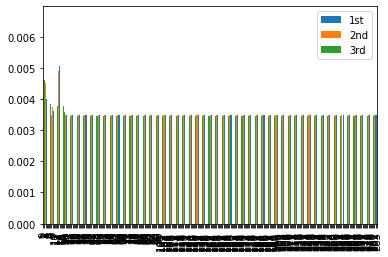

In [ ]:
index=[a for a in range(284)]
df = pd.DataFrame({'1st': v3[0][:284], '2nd': v3[1][:284], '3rd': v3[2][:284]},index=index)
ax = df.plot.bar()
# ax.title.set_text(text[3805])

In [ ]:
text[3805]

'Oppo का ये स्मार्टफ़ोन अब मिल रहा है रुपये में मिलता है MP कैमरा'

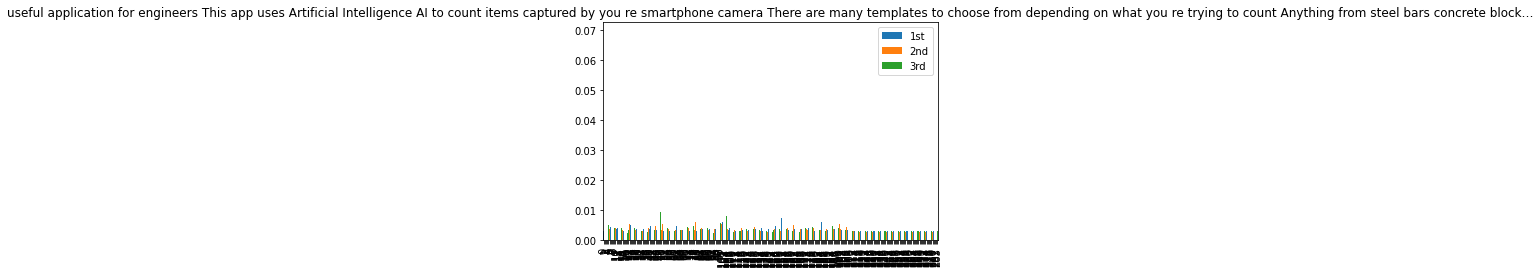

In [ ]:
index=[a for a in range(284)]
df = pd.DataFrame({'1st': v2[0][:284], '2nd': v2[1][:284], '3rd': v2[2][:284]},index=index)
ax = df.plot.bar()
ax.title.set_text(text[3456])

In [ ]:
f=np.array([[2,3,4],[4,5,6]])
np.mean(f,axis=0)

array([3., 4., 5.])

In [ ]:
from scipy.special import softmax
softmax(np.mean(f,axis=0))

Loss    1.0
dtype: float64